# 소비자 데이터 기반 소비 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme()

In [3]:
SEED = 22

In [8]:
os.chdir('C:/Users/Jaesu/github_desktop/Dacon-Basic/소비자-소비-예측')

In [548]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

|변수 이름|세부 사항|
|:-:|:-:|
|id| 샘플 아이디|
|Year_Birth | 고객 생년월일|
|Education | 고객 학력|
|Marital_status | 고객 결혼 상태|
|Income | 고객 연간 가구 소득|
|Kidhome | 고객 가구의 자녀 수|
|Teenhome | 고객 가구의 청소년 수|
|Dt_Customer | 고객이 회사에 등록한 날짜|
|Recency | 고객의 마지막 구매 이후 일수|
|NumDealsPurchases | 할인된 구매 횟수|
|NumWebPurchases | 회사 웹사이트를 통한 구매 건수|
|NumCatalogPurchases | 카탈로그를 사용한 구매 수| 
|NumStorePurchases | 매장에서 직접 구매한 횟수|
|NumWebVisitsMonth | 지난 달 회사 웹사이트 방문 횟수|
|AcceptedCmp1| 고객이 첫 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|AcceptedCmp2| 고객이 두 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|AcceptedCmp3| 고객이 세 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|AcceptedCmp4| 고객이 네 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|AcceptedCmp5| 고객이 다섯 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|Complain | 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0|
|Response | 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|target | 고객의 제품 총 소비량|

In [549]:
df.shape, test.shape

((1108, 22), (1108, 21))

In [550]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

`-` 결측치는 없다

## 데이터 전처리

`-` Dt_Customer(고객이 회사에 등록한 날짜) 변수가 문자형으로 되어있다

`-` 이를 날짜 형식으로 바꿔주자

In [551]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

`-` 연, 월, 일을 새로운 변수로 만들자

In [552]:
df['Dt_Customer_year'] = df['Dt_Customer'].dt.year
df['Dt_Customer_month'] = df['Dt_Customer'].dt.month
df['Dt_Customer_day'] = df['Dt_Customer'].dt.day

`-` `Dt_Customer` 변수는 쓸모를 다했으니 drop 하겠다

In [553]:
df.drop('Dt_Customer', axis=1, inplace=True)

`-` 캠페인에서 한 번이라도 수락했으면 그렇지 않은 사람과 차이가 있을 것 같다

`-` 이를 구분하기 위한 새로운 피쳐를 만들자

`-` 캠페인에 한 번 참여한 사람과 여러번 참여한 사람도 구분할까 했는데

`-` 2번보다 많이 참여한 사람이 100명도 안되서 안하기로 했다(2번: 51, 3번: 17, 4번: 6)

In [554]:
df['AcceptedCmp_any'] = (df['AcceptedCmp1'] +
                         df['AcceptedCmp2'] +
                         df['AcceptedCmp3'] +
                         df['AcceptedCmp4'] +
                         df['AcceptedCmp5']).apply(lambda x: 1 if x >= 1 else 0)

`-` `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`를 종합해서 전체 구매 횟수 변수를 생성하겠다

`-` 전체 구매 횟수에서 `NumDealsPurchases`만큼 제외하면 할인을 받지 않고 구매한 건수가 된다

In [555]:
df['TotalPurchases'] = df['NumStorePurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] ## 전체 구매 횟수
df['NotSalePurchases'] = df['TotalPurchases'] - df['NumDealsPurchases'] ## 할인 받지 않은 구매 횟수

`-` 할인 받지 않은 구매 횟수에 음수가 있어서 이를 제거하겠다

In [556]:
df = df.query('NotSalePurchases >= 0').reset_index().drop('index', axis=1)

`-` 한편, 범주형 변수인데 수치로 인코딩된 변수가 있다

`-` 이를 범주형 변수로 만들어주겠다

`-` 하는 김에 문자형으로 인코딩된 변수도 카테고리형 변수로 만들어주겠다

`-` 자녀수 같은 변수는 가질 수 있는 값(많아봐야 보통은 3)이 한정되어 있으니 범주형 변수로 만들것이다

In [557]:
def feature_engineering(df_) -> pd.DataFrame:
    df = df_.copy()

    ## 캠페인 수락
    df['AcceptedCmp_any'] = (df['AcceptedCmp1'] +
                             df['AcceptedCmp2'] +
                             df['AcceptedCmp3'] +
                             df['AcceptedCmp4'] +
                             df['AcceptedCmp5']).apply(lambda x: 1 if x >= 1 else 0)
    
    ## 구매 횟수
    df['TotalPurchases'] = df['NumStorePurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] ## 전체 구매 횟수
    df['NotSalePurchases'] = df['TotalPurchases'] - df['NumDealsPurchases'] ## 할인 받지 않은 구매 횟수
    
    ## 날짜
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
    df['Dt_Customer_year'] = df['Dt_Customer'].dt.year
    df['Dt_Customer_month'] = df['Dt_Customer'].dt.month
    df['Dt_Customer_day'] = df['Dt_Customer'].dt.day
    
    return df

In [558]:
def move_target_end(df) -> None:
    """target column을 마지막 column으로 이동시키는 함수"""
    target = df['target']
    df.drop('target', axis=1, inplace=True)
    df['target'] = target

In [559]:
def to_int(df) -> None:
    categorical_feature = ['Kidhome', 'Teenhome', 
                           'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp_any',
                           'Complain', 'Response']
    
    for feature in categorical_feature:
        df[feature] = df[feature].astype('int')

In [560]:
def to_category(df) -> None:
    categorical_feature = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
                           'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp_any', 
                           'Complain', 'Response']
    
    for feature in categorical_feature:
        df[feature] = df[feature].astype('category')

In [561]:
move_target_end(df)

In [562]:
to_category(df)

- test data

In [563]:
test = feature_engineering(test)

In [564]:
to_category(test)

## EDA

### 범주형 변수 시각화

In [222]:
def show_unique_counts(df_: pd.DataFrame, target: str = None) -> None:
    """ df의 변수 중에서 범주형 변수의 unique한 값의 개수를 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    ## len(df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## ex: 결과값이 12이므로 4 X 3 크기의 figure를 만들자
    row, column = 4, 3
    fig, axs = plt.subplots(row, column, figsize=(15, 20))
    features = df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        order = df_[feature].sort_values().unique() ## dropna() 때문에 사라진 범주가 있어서 삭제 전의 df_를 기준으로 order를 만듦
        if target is not None:
            gg = sns.histplot(data=df, y=feature, hue=target, multiple='stack', shrink=0.8, discrete=True, ax=ax)
        else:
            gg = sns.countplot(data=df, x=feature, ax=ax)
            
        # max_width = max([p.get_width() for p in gg.patches]) 
        # sns.move_legend(gg, 'lower right', title='income') ## target이 not None일 때 실행

        if target is not None:
            for j, p in enumerate(gg.patches):
                try:
                    condition = f'{feature} == "{order[j]}"'
                    aa = df.query(condition)['target'].value_counts()
                    success = '>50K' ## success는 수동으로 알맞게 지정해야 한다
                    text = np.round((100 * aa.to_dict().pop(success, 0) / sum(aa)), 2) ## text => (success) / sum(success, fail_1, fail_2, ..., fail_k) ---> target의 범주가 k+1개
                    gg.annotate('{:.2f}%'.format(text), (p.get_width() + 0.05*max_width, p.get_y() + 0.5*p.get_height() + 0.06)) ## text의 위치 조정
                except:
                    pass
                
    ## 남는 서브 플랏은 삭제하자
    for ax in axs: ## axs의 row
        for k in range(column): ## axs의 column
            if not ax[k].has_data(): 
                fig.delaxes(ax[k]) ## 남는 서브 플랏이니 삭제한다

    fig.suptitle("Categorical feature's Unique Counts\n\n", x=0.56, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

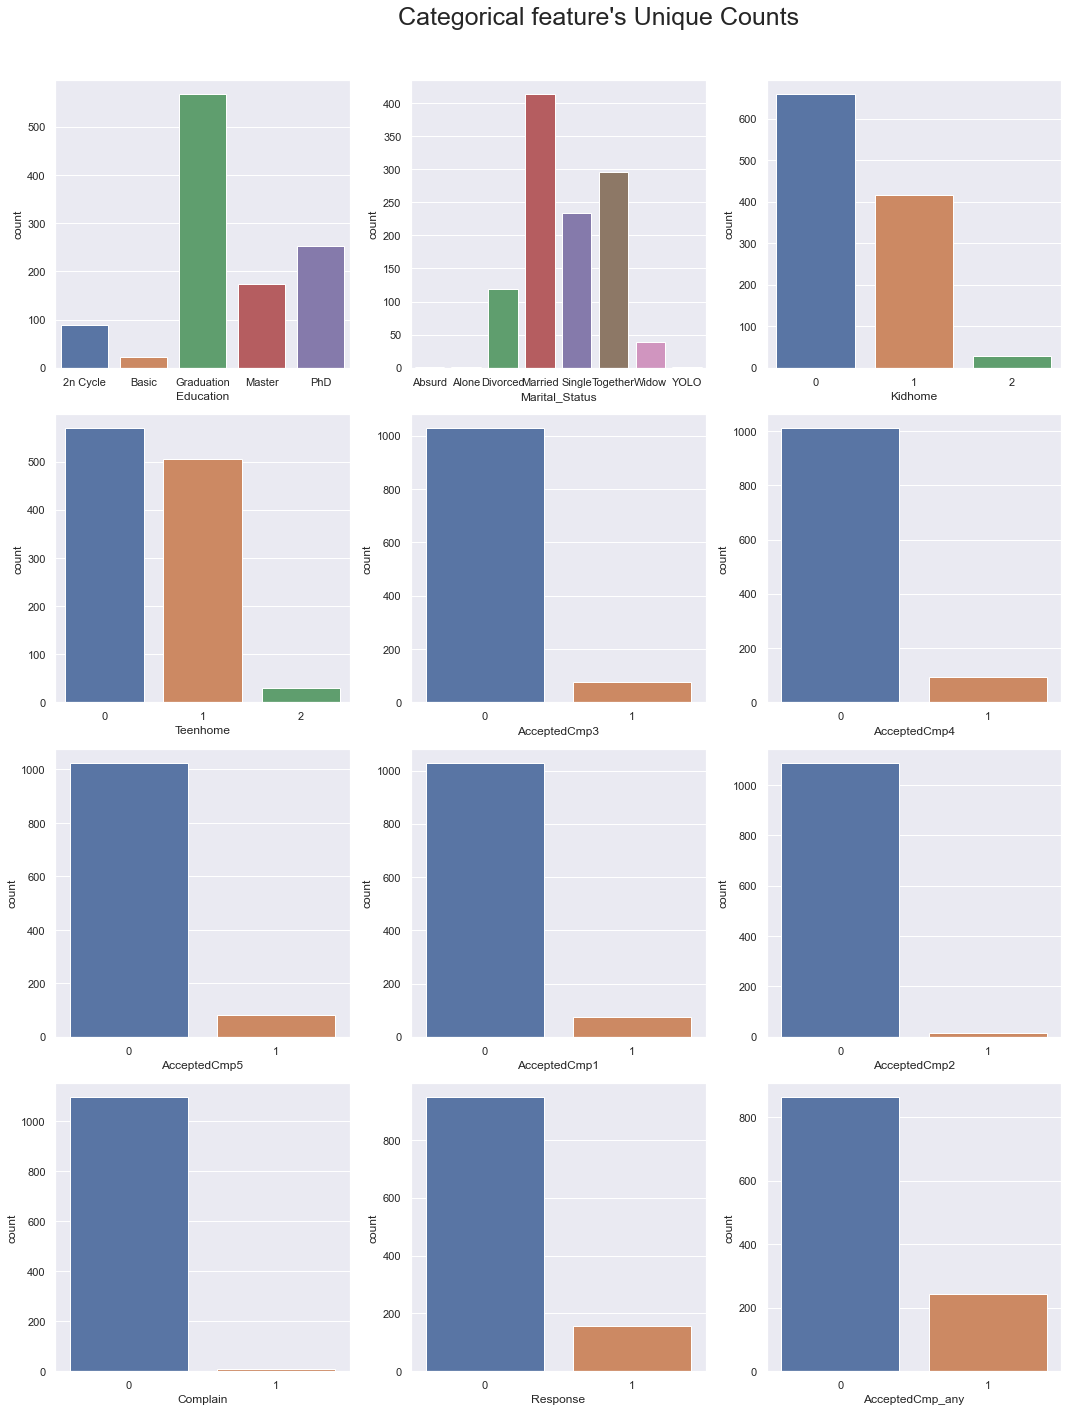

In [223]:
show_unique_counts(df)

`-` Marital_Status에서 'Alone', 'YOLO', 'Absurd'는 데이터가 극히 작고 Single에 범주에 포함되므로 single로 통합시켜 분석할 수도 있습니다

`-` Kidhome와 Teenhome에서 자녀 및 청소년을 2명둔 사람은 소수다

`-` 또한 Teenhome은 Kidhome에서 청소년인 경우만 집계한 것이기에 다중공선성 우려가 있다

`-` 청소년이냐 아니냐가 소비에 영향을 주지 않는다면 Teenhome은 쓰지 않아야 한다

`-` `AcceptedCmp 1~5`에서 보면 1(캠페인 참여)의 데이터가 매우 적다

`-` Complain하는 사람은 없다 봐도 무방하다(1000명이 넘는 사람 중에서 10명 있음)

### 양적 변수 상관관계 시각화

In [224]:
def corr_heatmap(df_: pd.DataFrame) -> None:
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    
    features = [df.columns[i] for i, dtype in enumerate(df.dtypes) if dtype.name.find('int') != -1 or dtype.name.find('float') != -1] ## 숫자타입만 사용
    df_corr = df[features]
    corr = df_corr.corr(method='pearson')

    plt.figure(figsize=(16, 12))
    sns.heatmap(data = corr, annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
    plt.title('Correlation between features', fontsize=25)

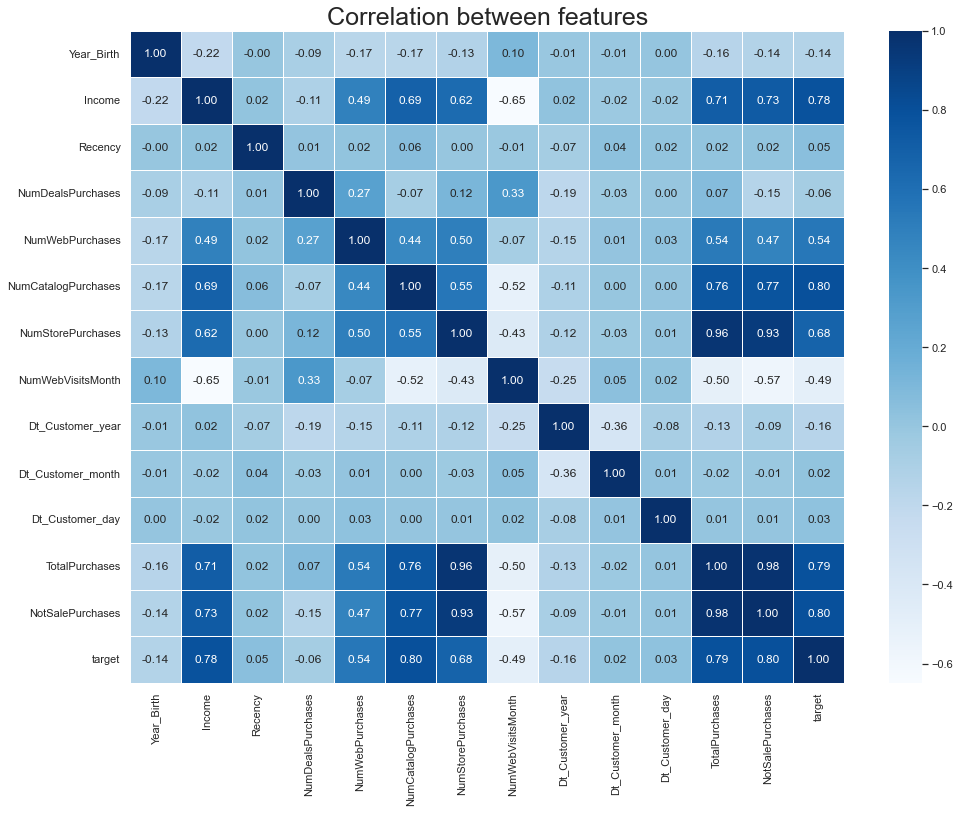

In [225]:
corr_heatmap(df.drop('id', axis=1))

`-` 다중공선성 유의해야 함

`-` 상관행렬 시각화

In [543]:
features = [df.columns[i] for i, dtype in enumerate(df.dtypes) if dtype.name.find('int') != -1 or dtype.name.find('float') != -1] ## 숫자타입만 사용

In [544]:
drop_columns = ['id', 'Year_Birth', 'Recency', 'Dt_Customer_year', 'Dt_Customer_month', 'Dt_Customer_day']

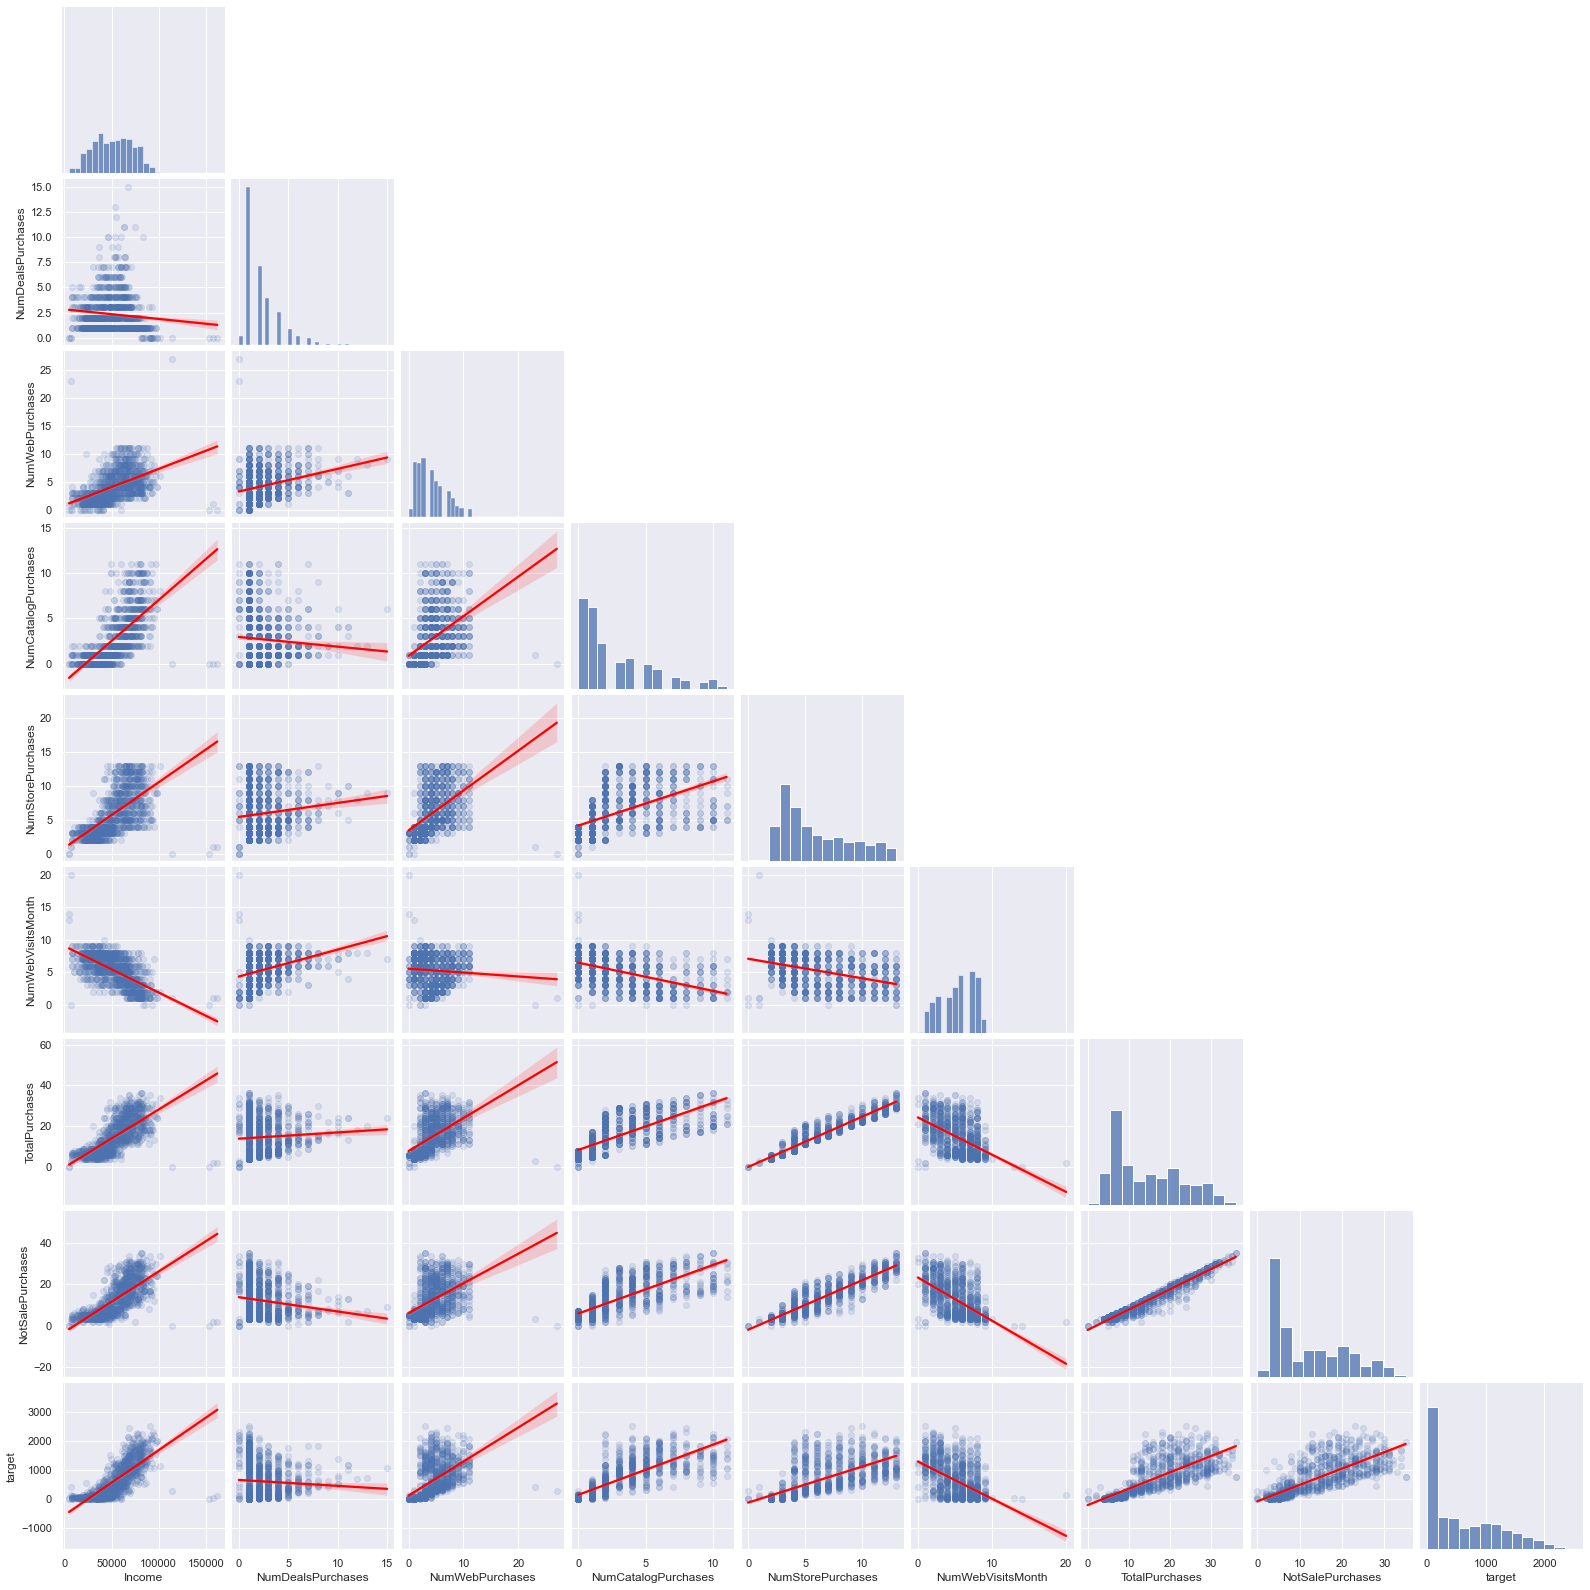

In [228]:
sns.pairplot(df,
             kind='reg',
             vars=[feature for feature in features if feature not in drop_columns],
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha':0.15}},
             corner=True)

`-` 전체 양적 변수를 가지고 시각화를 해봤는데 균일분포 성격을 띄는 변수가 있어서 제외하고 다시했다

`-` 위의 plot을 잘 보면 심각한 이상점과 영향점들이 존재한다

`-` 예컨대 `NumWebPurchases`의 경우 20을 넘는 2개의 영향점이 존재

`-` 이를 제거하면 상관계수도 조금 상승한다

`-` 모델링을 할 때 이상점과 영향점들을 제거해야 한다

`-` 또한 `Income` 변수가 가장 유용해보인다

`-` 그런데 웹사이트 방문 횟수가 많아지면 소비가 감소하는데 이유가 제품 환불하려고 웹사이트 들어가서 그런건가?

`-` 아니면 사지는 못하니 눈으로만 많이 보는건가?

`-` 고객의 제품 총 소비량은 환불에는 포함되지 않는게 맞겠지?

`-` 제품 총 소비량이니까 여태까지 쓴 소비량의 합일 것이다

`-` 그러면 회원가입 일자와 같은 변수가 충분히 영향을 끼칠 수 있을 것이다

`-` 그런데 위의 변수들이 범주형 변수의 의해 군집화 되어있을 수도 있다

- 자식의 수

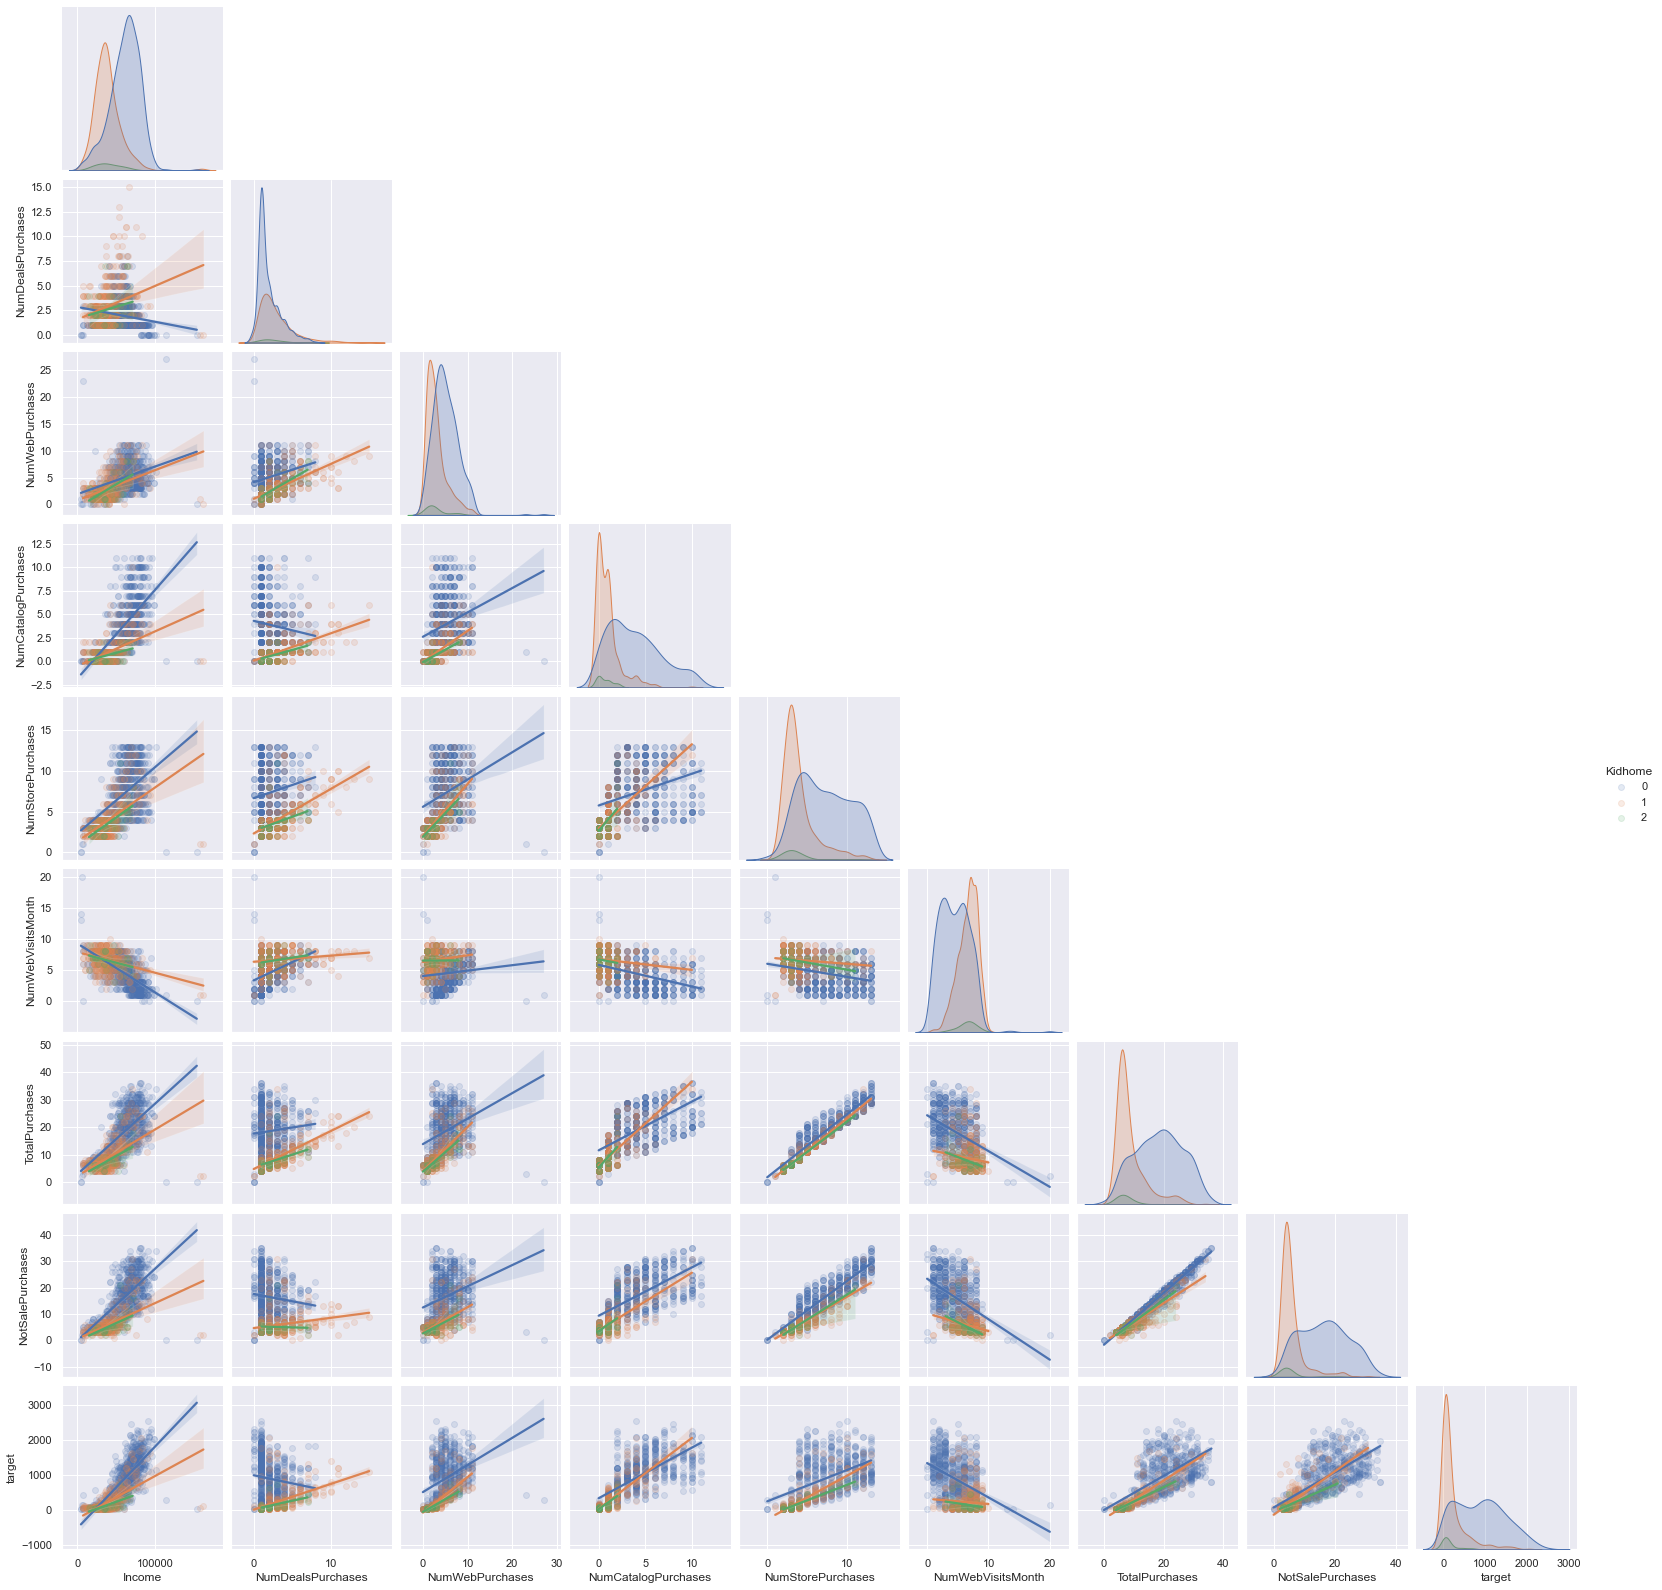

In [229]:
sns.pairplot(df,
             kind='reg',
             hue='Kidhome',
             vars=[feature for feature in features if feature not in drop_columns],
             plot_kws={'scatter_kws': {'alpha':0.15}},
             corner=True)

`-` `Response` 변수는 유용하지 않았다

`-` `Kidhome` 변수는 매우 유용해보인다(자식이 0명이냐 1명이냐에 따라 상관계수 부호도 달라지는 변수도 존재)

`-` 자식이 1명이냐 2명이냐는 큰 차이는 없어보인다(하나로 통일해도 될 듯하다)

`-` `Kidhome` 변수를 사용하여 교호작용을 추가할 수 있을 듯하다

- 자식(teen)의 수

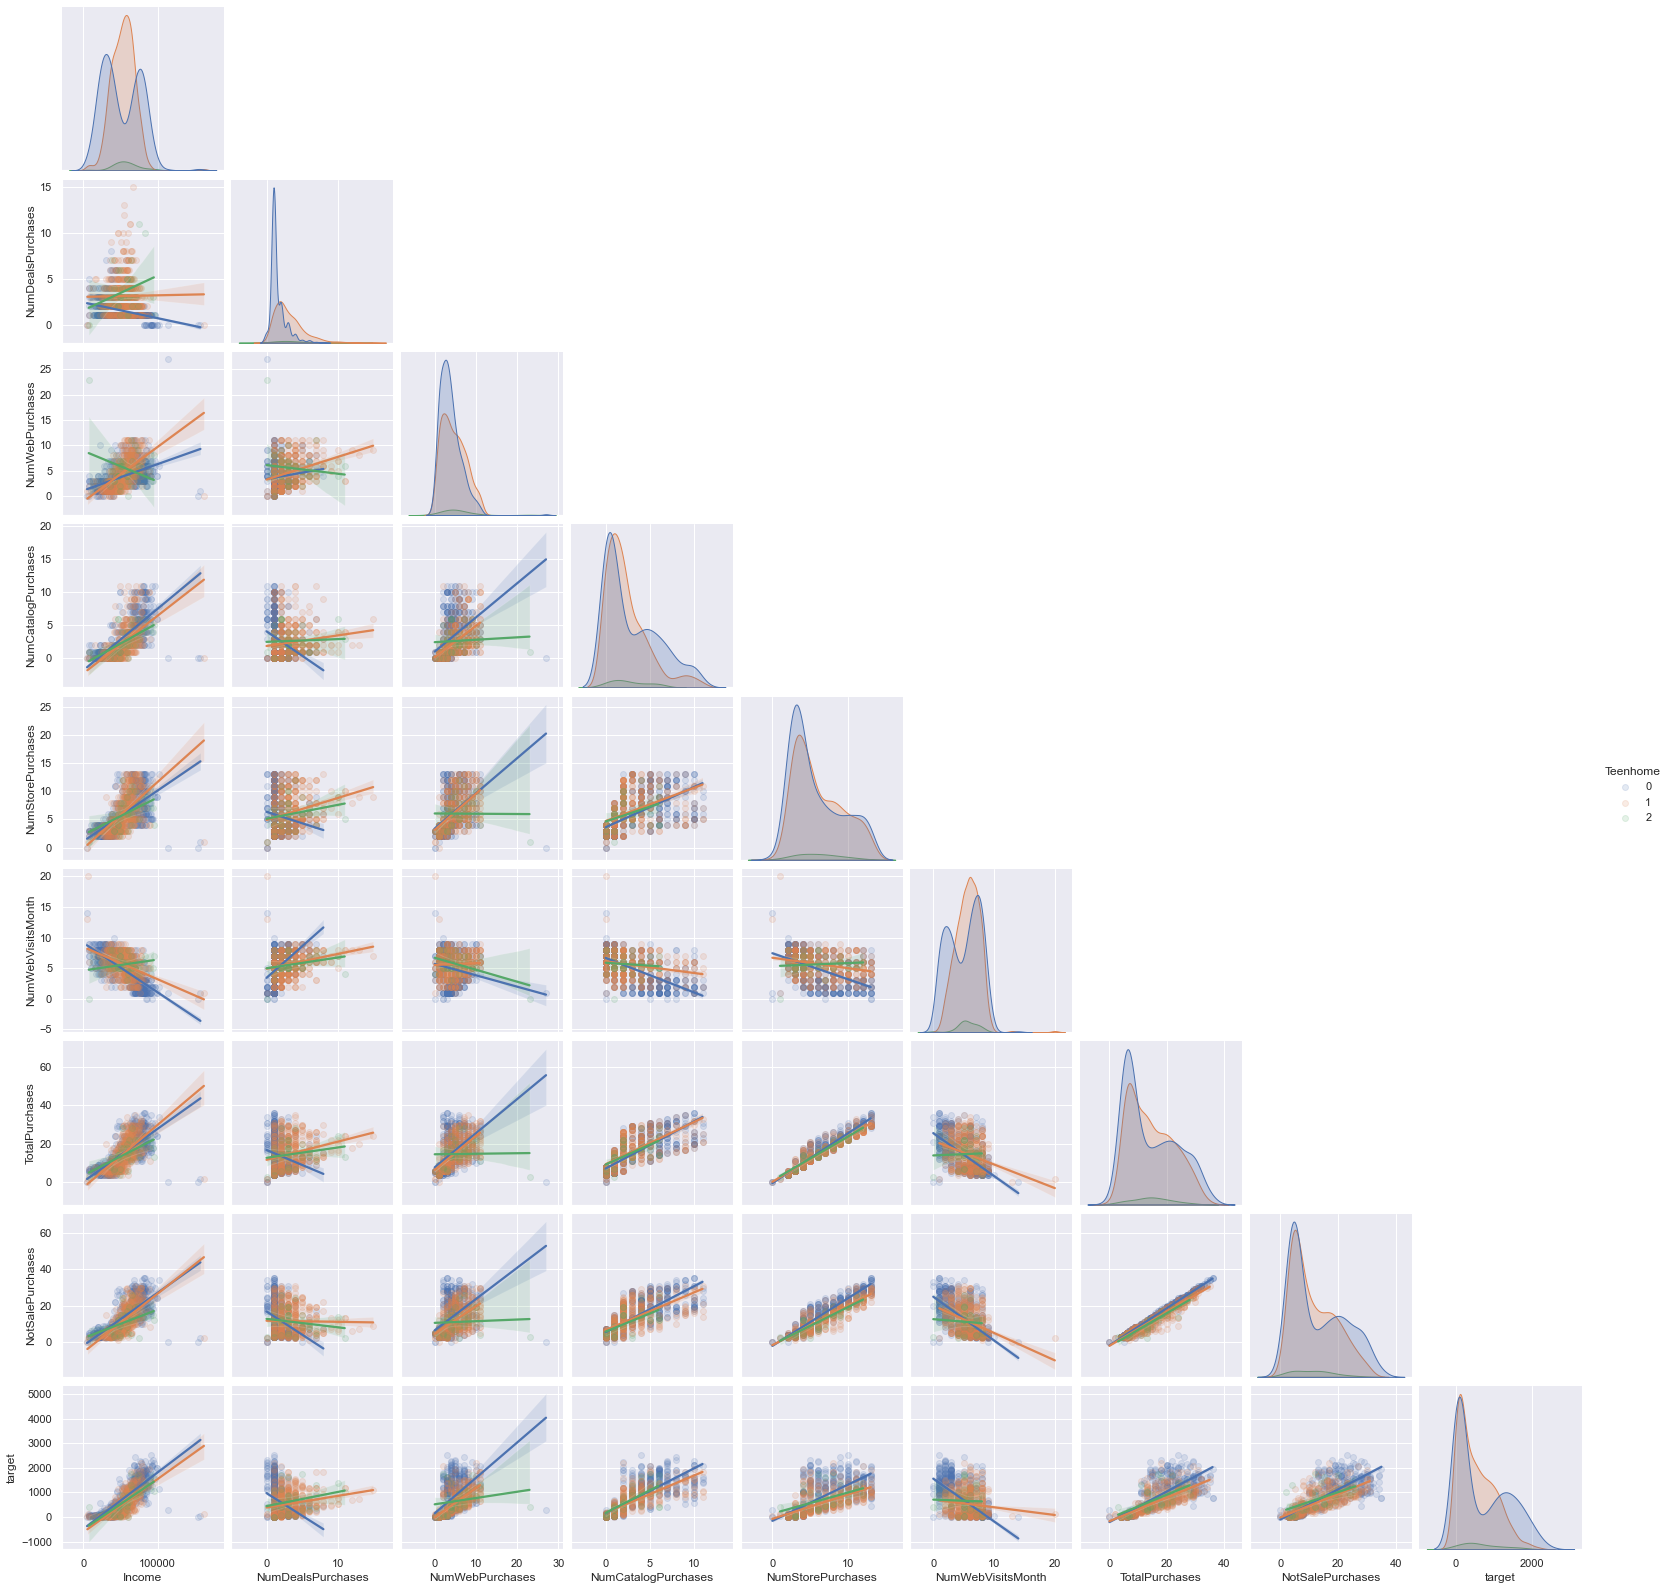

In [230]:
sns.pairplot(df,
             kind='reg',
             hue='Teenhome',
             vars=[feature for feature in features if feature not in drop_columns],
             plot_kws={'scatter_kws': {'alpha':0.15}},
             corner=True)

`-` `Teenhome` 변수도 유의해보인다(Kidhome 변수도 유의했으니 당연하다...)

`-` 둘다 쓰는게 좋은지 어느하나만 쓰는게 좋은지는 직접 모델링을 해봐야 정확하겠지만

`-` 내가 보기엔 `Kidhome` 변수만 쓰는 것이 나아보인다

`-` 왜냐하면 target을 예측하는데 있어 `Income`이 제일 중요해보이는데

`-` `Kidhome` 변수는 `Income` 변수와 교호작용이 있어보이지만 `Teenhome` 변수는 그렇지 않기 때문이다

- 캠페인 참여 유무

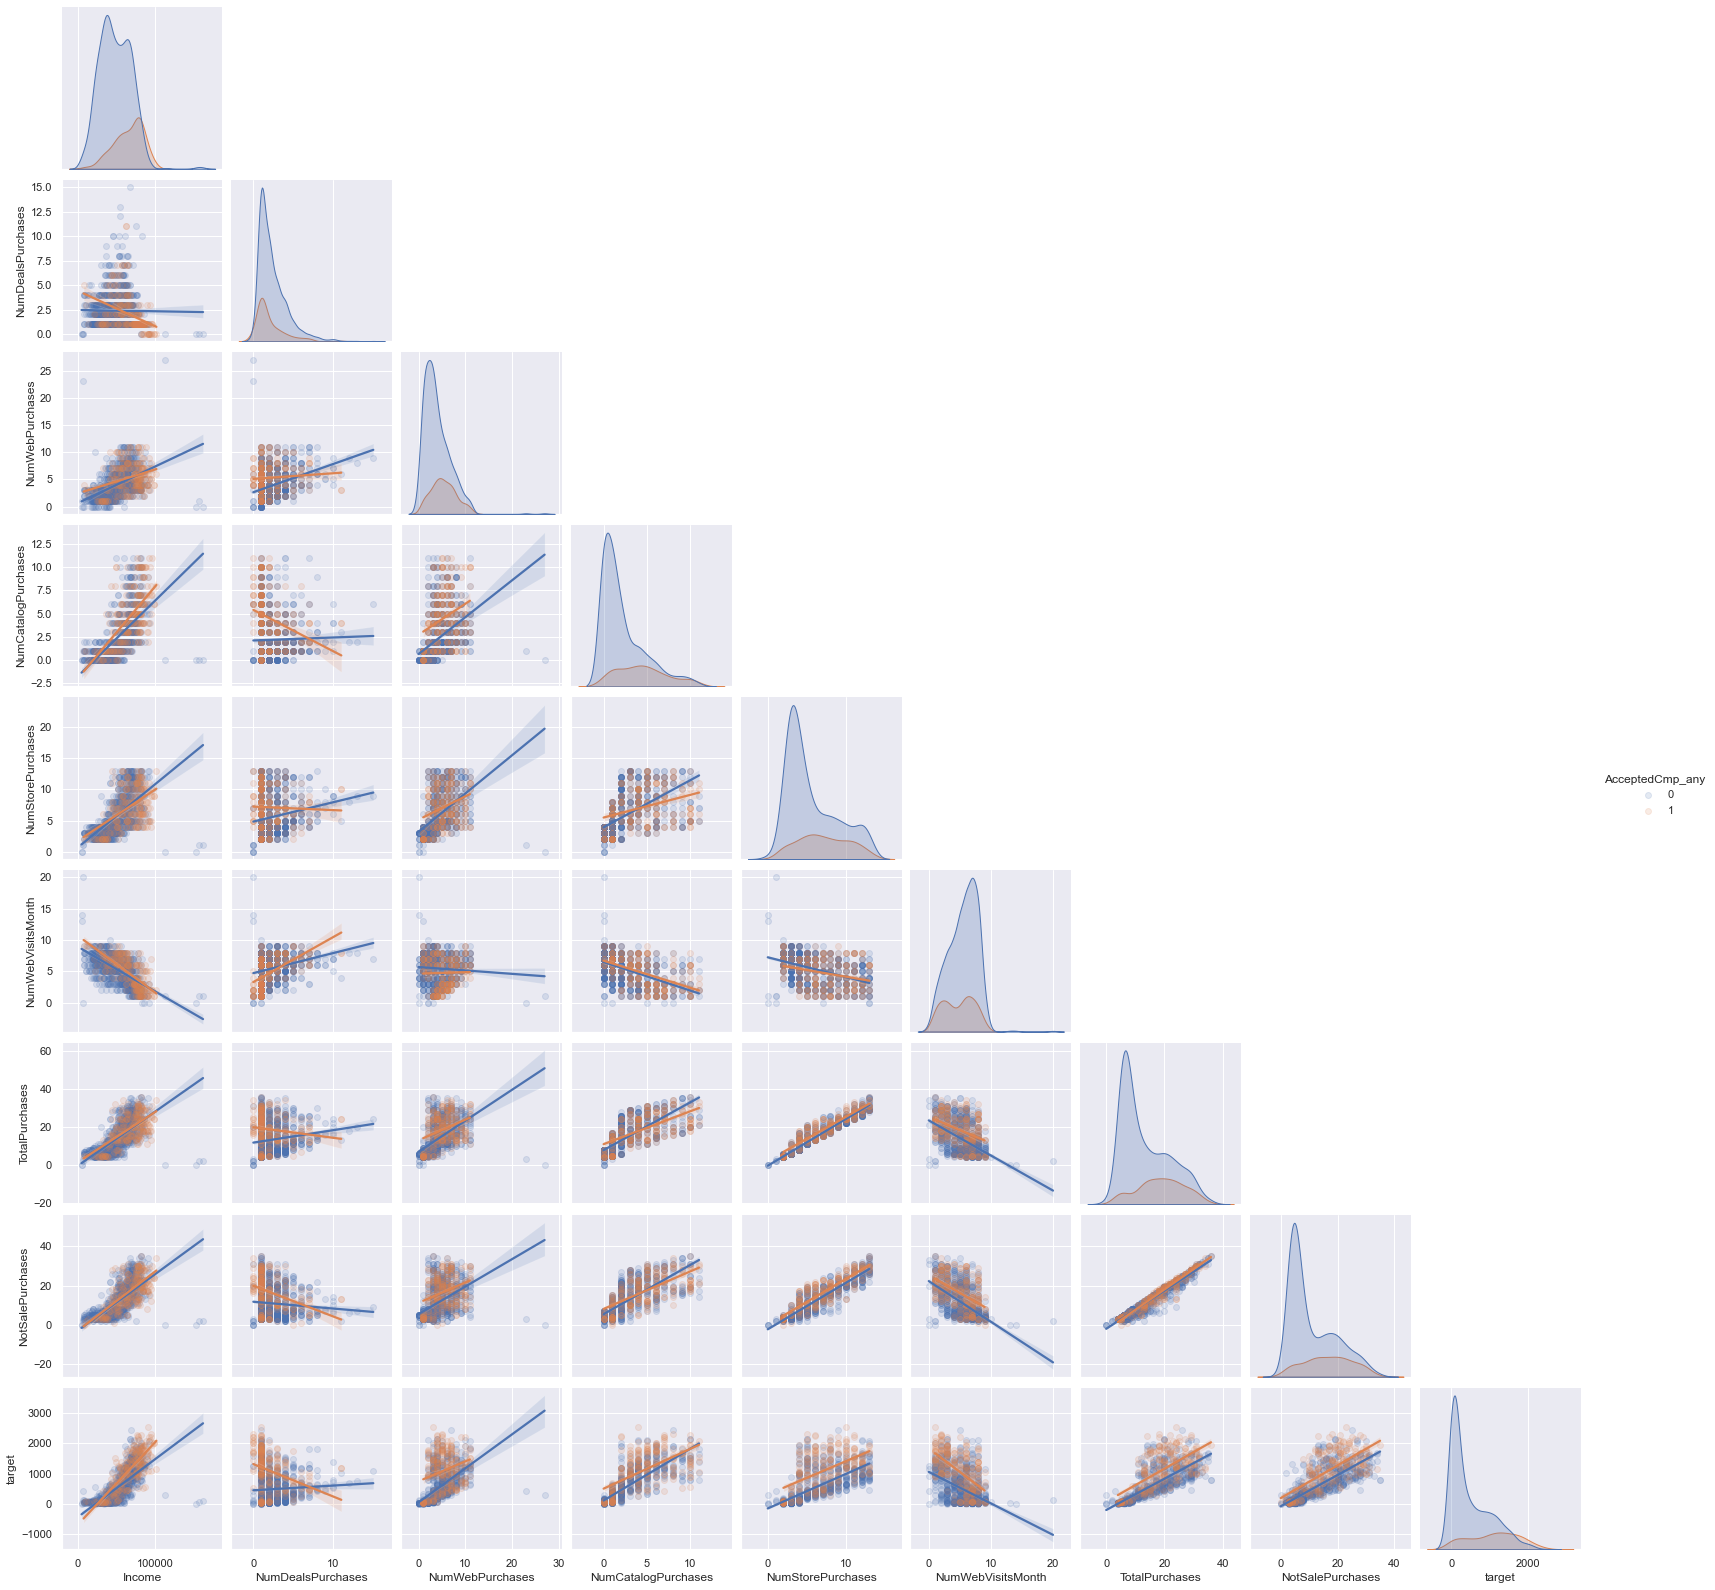

In [231]:
sns.pairplot(df,
             kind='reg',
             hue='AcceptedCmp_any',
             vars=[feature for feature in features if feature not in drop_columns],
             plot_kws={'scatter_kws': {'alpha':0.15}},
             corner=True)

`-` 캠페인에 한 번이라도 참여한 사람과 그렇지 않은 사람들간의 차이가 있어 보인다

`-` 혹시 회사에서 특정 기간동안 가입 이벤트를 해서 회원가입을 몇월에 했는지로 나눠서 탐색해봤는데

`-` 유의미한 차이가 없어보였다

`-` 년도와 월을 같이 봐야 정확하긴 한데 딱히 의미없을 듯하다

`-` 몇번째 캠페인을 수락했는지에 따라 차이가 있는지 확인해봤는데 유의한 차이는 없었다

`-` 위의 plot들을 보면 양봉분포가 많이 보이는데 이유는 모르겠다(단일 히스토그램을 보면 양봉분포로 보이지 않는다)

`-` 더 탐구해봐야 할 듯

### target 변수 시각화

<AxesSubplot:>

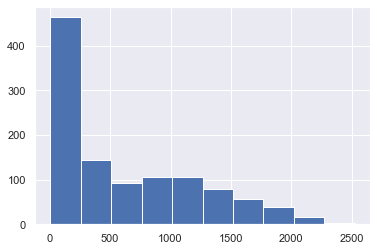

In [232]:
df.target.hist()

<AxesSubplot:>

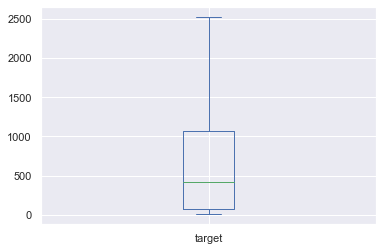

In [233]:
df.target.plot.box()

`-` target의 분포는 오른쪽으로 치우친 분포이다

`-` 근데 이상점은 존재하지 않는다

`-` 위의 plot을 보면 0 근처에 값이 꽤 많아보인다

<AxesSubplot:>

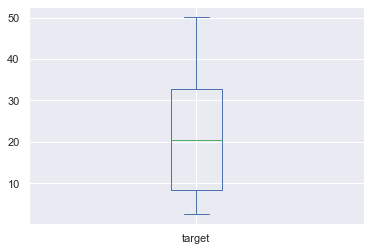

In [510]:
np.sqrt(df.target).plot.box()

`-` target에 제곱근 변환을 해주니 어느정도 대칭인 분포가 되었다

`-` 모델링할 때 제곱근 변환을 사용하겠다

<AxesSubplot:xlabel='Marital_Status', ylabel='target'>

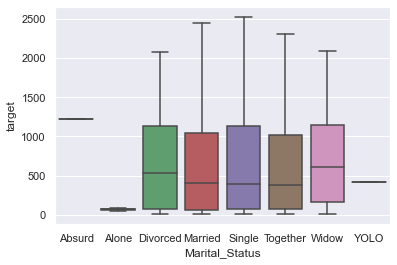

In [235]:
sns.boxplot(data=df, x='Marital_Status', y='target')

`-` 쓸모 없어 보인다

<AxesSubplot:xlabel='Education', ylabel='target'>

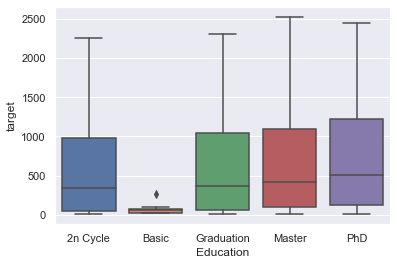

In [236]:
sns.boxplot(data=df, x='Education', y='target')

`-` 쓸모 없어 보인다2

<AxesSubplot:xlabel='Response', ylabel='target'>

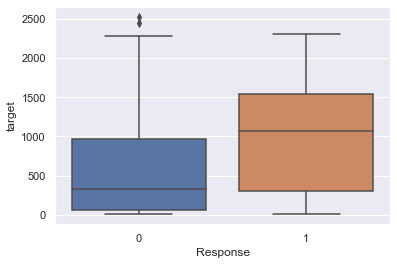

In [237]:
sns.boxplot(data=df, x='Response', y='target')

`-` 위에서 상관관계 시각화 했을 땐 쓸모 없어 보였는데 여기서는 쓸모 있어 보인다

`-` 교호작용은 없고 단순 절편에 영향을 끼치는 것 같다

<AxesSubplot:xlabel='Dt_Customer_year', ylabel='target'>

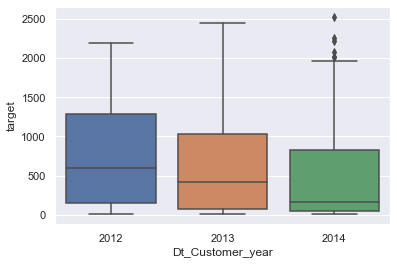

In [238]:
sns.boxplot(data=df, x='Dt_Customer_year', y='target')

`-` 소비는 누적되기 때문에 오래전에 가입한 사람들의 소비량이 많은편이다

`-` 이외의 날짜 관련 변수는 시각화 해보니 쓸모 없어 보였다

`-` `Recency` 변수를 중앙값을 기준으로 범주화시켜서 시각화해봤는데 무쓸모였다

## 모델링

### 인코딩 및 이상점 제거

`-` 캠페인 참여와 관련된 변수는 `AcceptedCmp_any` 변수만 사용하겠다

`-` 날짜 관련 변수는 `Dt_Customer_year` 변수만 사용하겠다 

`-` 이외의 날짜 관련 변수는 target과 관련이 없어보여서 사용하지 않겠다

`-` `Education` 변수와 `Marital_Status` 변수는 target과 관련이 없어보여 사용하지 않겠다

`-` `Complain` 변수는 불만을 가진 고객이 10명으로 너무 적어 사용하지 않겠다

`-` 다중공선성 문제로 `Kidhome` 변수를 사용하고 `Teenhome` 변수는 사용하지 않겠다

`-` `Kidhome` 변수에서 자식이 2명이 경우는 매우 적어 1명이 경우와 통합하겠다

`-` 위에서 확인한 상관관계 히트맵을 통해 `Income`, `NumDealsPurchases`, `NumWebVisitsMonth` 변수와 `Kidhome` 변수간의 교호작용을 추가하겠다

`-` 또한 `Income`, `NumDealsPurchases` 변수와 `AcceptedCmp_any` 변수간의 교호작용을 추가하겠다

`-` 구매 횟수 관련 변수는 다중공선성 문제로 `NumDealsPurchases` 변수와 `TotalPurchases` 변수만 사용하겠다

In [565]:
df['Kidhome'] = df['Kidhome'].apply(lambda x: 1 if x == 2 else x)
test['Kidhome'] = test['Kidhome'].apply(lambda x: 1 if x == 2 else x)

In [566]:
def add_interaction(df_) -> pd.DataFrame:
    df = df_.copy()
    ## Kidhome
    for feature in ['Income', 'NumDealsPurchases', 'NumWebVisitsMonth']:
        df[f'Kidhome_{feature}'] = df['Kidhome'] * df[feature]    
    
    ## AcceptedCmp_any
    for feature in ['Income', 'NumDealsPurchases']:
        df[f'AcceptedCmp_{feature}'] = df['Kidhome'] * df[feature]
        
    return df

In [567]:
df = add_interaction(df)
test = add_interaction(test)

- 이상점 제거

`-` 위에서 수행한 시각화를 바탕으로 이상점을 제거하겠다

`-` `Income` 110000 이상인 경우 제거

`-` `NumWebPurchases` 20 이상인 경우 제거

`-` `NumWebVisitsMonth` 11 이상인 경우 제거

In [568]:
df = df.query('Income < 110000 and NumWebPurchases < 20 and NumWebVisitsMonth < 11').reset_index().drop('index', axis=1)

### 모델 생성 및 학습

In [571]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [109]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [627]:
def OOF_predict(model, X, y, test, SKfold, stratify):
    """
    Out-Of-Fold 방식을 통해 test(numeric)를 예측
    """ 
    model_train_score = []
    model_valid_score = []
    model_predict = np.zeros(shape=(test.shape[0]))

    for i, (train_idx, valid_idx) in enumerate(SKfold.split(X, X[stratify])):
        # print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        
        ## target에 제곱근 변환
        y_train = np.sqrt(y_train)
        
        ## 모델 적합
        model.fit(X_train, y_train)
        
        ## prediction
        train_predict = model.predict(X_train) ## train
        y_predict = model.predict(X_valid) ## valid
        test_predict = model.predict(test) ## test
        
        model_train_score.append(NMAE(np.square(y_train), np.square(train_predict))) ## train NMAE
        model_valid_score.append(NMAE(y_valid, np.square(y_predict))) ## valid NMAE
        model_predict += np.square(test_predict) / SKfold.n_splits ## test 예측값(k Fold)
              
    return model_train_score, model_valid_score, model_predict

In [578]:
to_int(df)
to_int(test)

In [579]:
features = ['Income', 'Kidhome', 'NumDealsPurchases', 
            'TotalPurchases', 'NumWebVisitsMonth',
            'AcceptedCmp_any', 'Response', 'Dt_Customer_year']

interaction_features = ['Kidhome_Income', 'Kidhome_NumDealsPurchases',
                        'Kidhome_NumWebVisitsMonth', 'AcceptedCmp_Income',
                        'AcceptedCmp_NumDealsPurchases']

In [580]:
target = df['target']
df.drop('target', axis=1, inplace=True)

In [581]:
df2 = df[features]
test2 = test[features]

In [616]:
df3 = df[features + interaction_features]
test3 = test[features + interaction_features]

In [582]:
k = 5
skfold = StratifiedKFold(k, shuffle=True, random_state=SEED)

`-` `Kidhome` 변수로 교호작용도 만든만큼 잘 섞여야 하므로 `StratifiedKFold` 사용

In [636]:
Lasso_train_NMAE, Lasso_valid_NMAE = [], []
alphas = np.linspace(0.01, 10, 300)

for alpha in alphas:
    LASSO = Lasso(alpha=alpha, random_state=SEED)
    train_NMAE, valid_NMAE, _ = OOF_predict(LASSO, df.loc[:,['Income', 'Kidhome']], target, test.loc[:,['Income', 'Kidhome']], skfold, stratify='Kidhome') 
    Lasso_train_NMAE.append(np.mean(train_NMAE))
    Lasso_valid_NMAE.append(np.mean(valid_NMAE))

`-` $\alpha$값에 따른 NMAE 시각화